In [1]:
import xarray as xr
import numpy as np
import dask as dask
from matplotlib import pyplot as plt
%matplotlib inline
import intake
import pandas as pd
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
import gsw

Sea water's Equation of State:
$$ \rho \simeq \rho_0 \left [ 1 - \frac{gz}{c_0^2} - \alpha_0(1 - \gamma_B z)(\Theta - \Theta_0)\frac{\gamma_C}{2}(\Theta - \Theta_0)^2 + \beta_0 (SA - S{A0} ) \right ] $$

In [2]:
#Gyre actually has the data file so instead of doing intake which takes a while when computing things, 
#you can just get it directly from Gyre using xarray zarr
ds_sose = xr.open_zarr('/swot/SUM03/tmp/SOSE')
ds_sose

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
    Depth     (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    PHrefC    (Z) float32 dask.array<shape=(42,), chunksize=(42,)>
    PHrefF    (Zp1) float32 dask.array<shape=(43,), chunksize=(43,)>
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
    drC       (Zp1) float32 dask.ar

In [3]:
ds_sose.SFLUX.units

'g/m^2/s'

In [4]:
ds_sose.TFLUX.units

'W/m^2'

# Pressure Level 0km

In [5]:
sst = ds_sose.THETA.isel(Z=0)
sss = ds_sose.SALT.isel(Z=0)

Apply ufunc is doing several things for us:

1. Feeds the raw numpy arrays to the specified function (ufunc), in this case, `gsw.SA_from_SP`.
2. It broadcast the input arrays (`sss`, `0`, `XC`, and `YC`) into compatible shapes so numpy can operate on them together.
3. It automatically parallelizes the execution across all the chunks in a dask array
4. It wraps the output back in in xarray data array

In [6]:
#lazy mode
#converting practical salinity to absolute salinity
sa = xr.apply_ufunc(gsw.SA_from_SP, sss, 0, ds_sose.XC, ds_sose.YC,
                    output_dtypes=[sss.dtype],
                    dask='parallelized').reset_coords(drop=True)
sa

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [7]:
#converting potential temperature to conservative temperature
ct = xr.apply_ufunc(gsw.CT_from_pt, sa, sst,
                    output_dtypes=[sss.dtype],
                    dask='parallelized').reset_coords(drop=True)
ct

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/gsw/_wrapped_ufuncs.py:644: RuntimeWarning: invalid value encountered in ct_from_pt
  return _gsw_ufuncs.ct_from_pt(SA, pt)


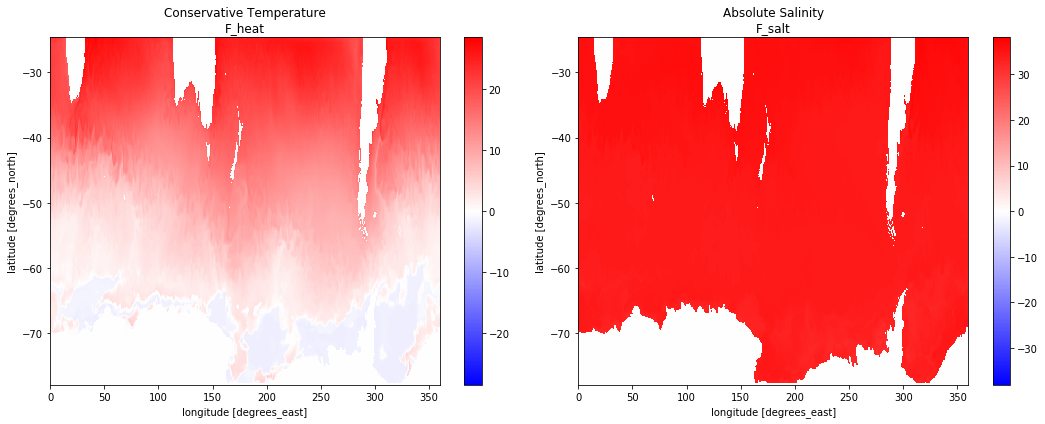

In [8]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15,6))
ct[0].plot(ax=ax0, cmap='bwr')
ax0.set_title('Conservative Temperature\nF_heat')
sa[0].plot(ax=ax1, cmap='bwr')
ax1.set_title('Absolute Salinity\nF_salt')
plt.tight_layout();

## Compute density flux $$ units\ of\ \frac{kg}{m^{2}s} $$
$$
F_{\sigma} = F_{heat}\frac{\partial\sigma}{\partial\theta} + F_{salt}\frac{\partial\sigma}{\partial S}\
$$

$$
\alpha = - \frac{1}{\rho_{0}} \frac{\partial\rho}{\partial \theta}
$$

$$
\beta = \frac{1}{\rho_{0}} \frac{\partial\rho}{\partial S}
$$

In [9]:
runit2mass = 1.035e3 #rho_not
heat_capacity_cp = 3.994e3 #J/˚K/kg

## alpha at P = 0, 2000, 3000, 4000m

In [10]:
#thermal expansion coefficient
alpha_0 = xr.apply_ufunc(gsw.alpha, sa, ct, 0,
                    output_dtypes=[sst.dtype],
                    dask='parallelized').reset_coords(drop=True)
alpha_0

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [11]:
a0 = alpha_0[0].load()

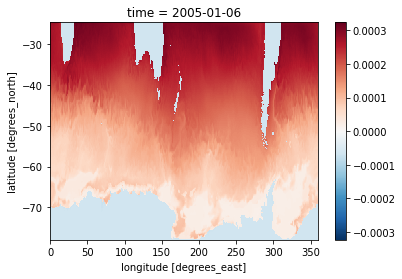

In [12]:
a0.plot()

## beta at P = 0, 2000, 3000, 4000m

In [13]:
#haline contraction coefficient
beta_0 = xr.apply_ufunc(gsw.beta, sa, ct, 0,
                      output_dtypes=[sss.dtype],
                      dask='parallelized').reset_coords(drop=True)
beta_0

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

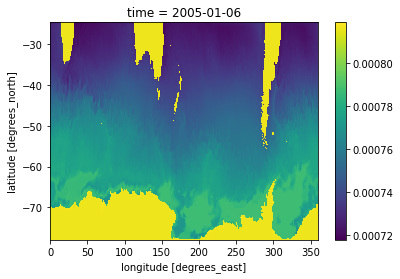

In [14]:
beta_0[0].plot()

## Temperature component of F_sigma at 4 different reference pressures

$$
F_{\sigma_{heat}} = \alpha \rho_{0} \frac{Q}{\rho_{0}c_{p}} = \alpha \frac{Q}{c_{p}}
$$

### Reference Pressure 0

In [15]:
ds_sose.TFLUX

<xarray.DataArray 'TFLUX' (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
    rA       (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      total heat flux (match heat-content variations), >0 incre...
    standard_name:  TFLUX
    units:          W/m^2

In [16]:
F_sig_heat = (alpha_0 * ds_sose.TFLUX) / heat_capacity_cp
F_sig_heat #kg/m^2/s

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
    rA       (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>

Text(0.5, 1.0, 'temperature component of\ndensity flux\nat t=0')

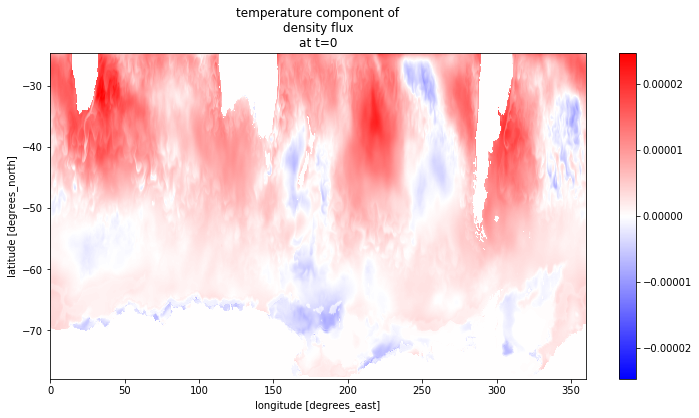

In [17]:
F_sig_heat[0].plot(figsize=(12,6), cmap='bwr')
plt.title('temperature component of\ndensity flux\nat t=0')

In [18]:
#temperature annual mean
group_time_heat = F_sig_heat.groupby('time.month').mean(dim='time')
ann_mean_heat = group_time_heat.mean(dim='month')
ann_mean_heat.load()

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (YC: 320, XC: 2160)>
array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [2.148566e-06, 2.142624e-06, 2.135503e-06, ..., 2.126619e-06,
        2.136126e-06, 2.146468e-06],
       [2.240010e-06, 2.235710e-06, 2.230877e-06, ..., 2.210086e-06,
        2.220978e-06, 2.234744e-06],
       [2.292005e-06, 2.288993e-06, 2.284815e-06, ..., 2.259152e-06,
        2.269410e-06, 2.284717e-06]], dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 

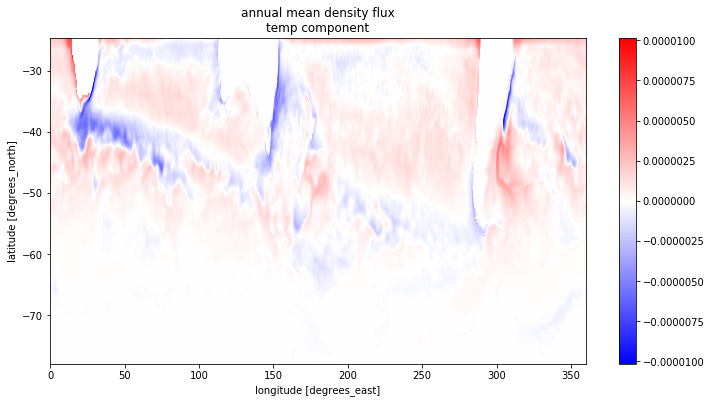

In [19]:
ann_mean_heat.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean density flux\ntemp component');

In [20]:
#OFF BY A FACTOR OF 10e-1
#density flux to buoyancy flux -> multiply by (-g/rho_0)
#to get ferrari's mm^2 units *10e6
buoyancy_flux_heat = (ann_mean_heat*(-9.81)*10e6) / (10*runit2mass)
buoyancy_flux_heat

<xarray.DataArray (YC: 320, XC: 2160)>
array([[-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       ...,
       [-0.020365, -0.020308, -0.020241, ..., -0.020157, -0.020247, -0.020345],
       [-0.021231, -0.021191, -0.021145, ..., -0.020948, -0.021051, -0.021181],
       [-0.021724, -0.021696, -0.021656, ..., -0.021413, -0.02151 , -0.021655]],
      dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 ... 311911140.0 311911140.0

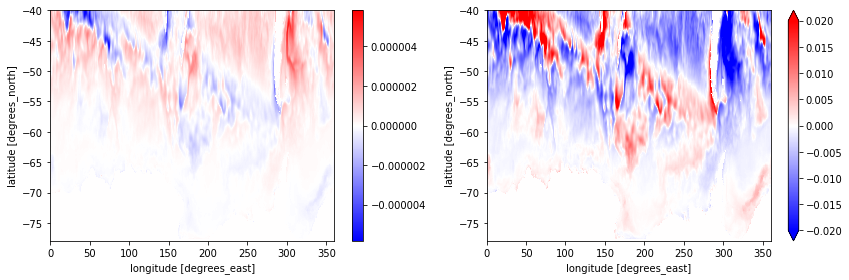

In [131]:
fig, axes = plt.subplots(figsize=(12,4), ncols=2)
ann_mean_heat.sel(YC=slice(-80,-40)).plot(ax=axes[0], cmap='bwr')
buoyancy_flux_heat.sel(YC=slice(-80,-40)).plot(ax=axes[1], cmap='bwr', vmin=-0.02, vmax=0.02)
plt.tight_layout()

Text(0.5, 1.0, 'annual mean buoyancy flux\ntemp component')

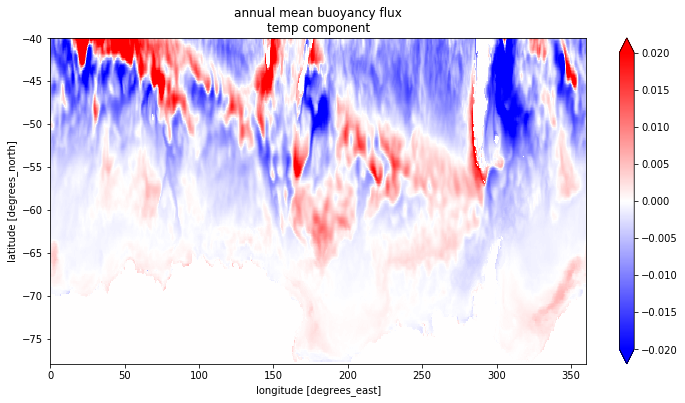

In [116]:
buoyancy_flux_heat.sel(YC=slice(-80,-40)).plot(figsize=(12,6), cmap='bwr', vmin=-0.02, vmax=0.02)
plt.title('annual mean buoyancy flux\ntemp component')

### Salinity component of F_sigma

$$
F_{\sigma_{salt}} = \beta \frac{(E-P-R)}{\rho_{fw}} = \beta*SFLUX
$$

In [22]:
F_sig_salt = beta_0 * ds_sose.SFLUX
F_sig_salt

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
    rA       (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>

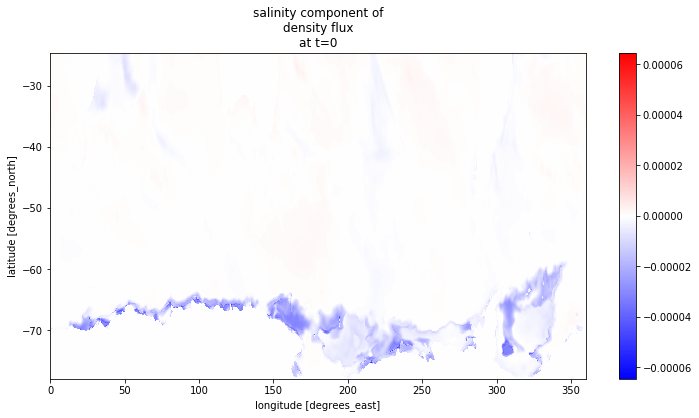

In [23]:
F_sig_salt[0].plot(figsize=(12,6), cmap='bwr')
plt.title('salinity component of\ndensity flux\nat t=0');

In [24]:
#temperature annual mean
group_time_salt = F_sig_salt.groupby('time.month').mean(dim='time')
ann_mean_salt = group_time_salt.mean(dim='month')
ann_mean_salt.load()

<xarray.DataArray (YC: 320, XC: 2160)>
array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [1.033410e-06, 1.035154e-06, 1.036505e-06, ..., 1.026301e-06,
        1.028206e-06, 1.030716e-06],
       [1.030928e-06, 1.032323e-06, 1.033466e-06, ..., 1.025113e-06,
        1.026728e-06, 1.028778e-06],
       [1.032347e-06, 1.033610e-06, 1.034825e-06, ..., 1.027313e-06,
        1.028822e-06, 1.030549e-06]], dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 

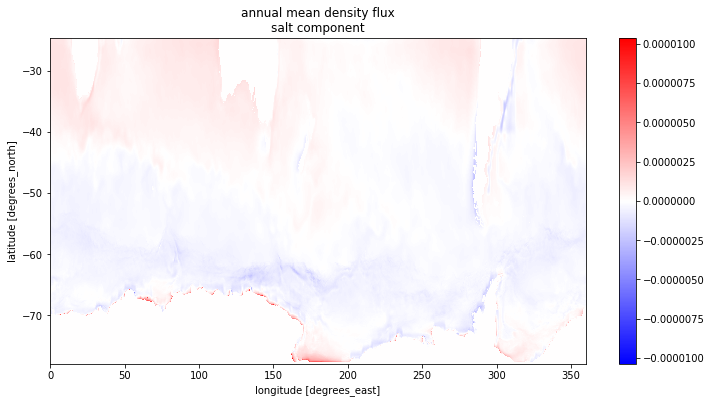

In [25]:
ann_mean_salt.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean density flux\nsalt component');

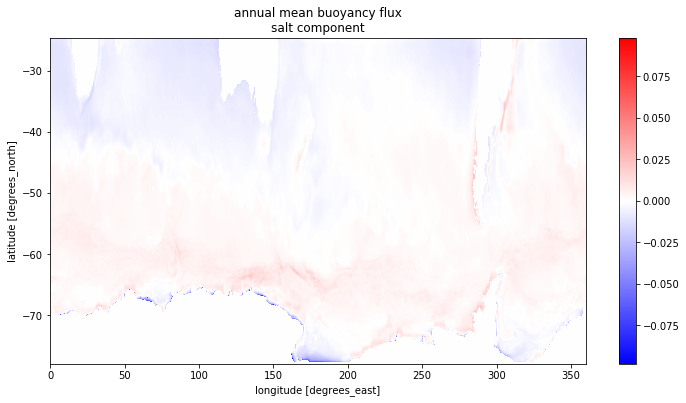

In [26]:
#density flux to buoyancy flux -> multiply by (-g/rho_0)
#to get ferrari's mm^2 units *10e6
buoyancy_flux_salt = ann_mean_salt*(-9.81)*10e6/ (10*runit2mass)
buoyancy_flux_salt.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean buoyancy flux\nsalt component');

## Total Buoyancy Flux at different reference pressure levels $$with\ units\ of\ \frac{mm^{2}}{s^{3}} $$

In [27]:
buoyancy_flux_total = buoyancy_flux_heat + buoyancy_flux_salt
buoyancy_flux_total

<xarray.DataArray (YC: 320, XC: 2160)>
array([[-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       ...,
       [-0.03016 , -0.03012 , -0.030065, ..., -0.029884, -0.029992, -0.030114],
       [-0.031003, -0.030975, -0.03094 , ..., -0.030664, -0.030783, -0.030933],
       [-0.031509, -0.031493, -0.031464, ..., -0.03115 , -0.031262, -0.031423]],
      dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 ... 311911140.0 311911140.0

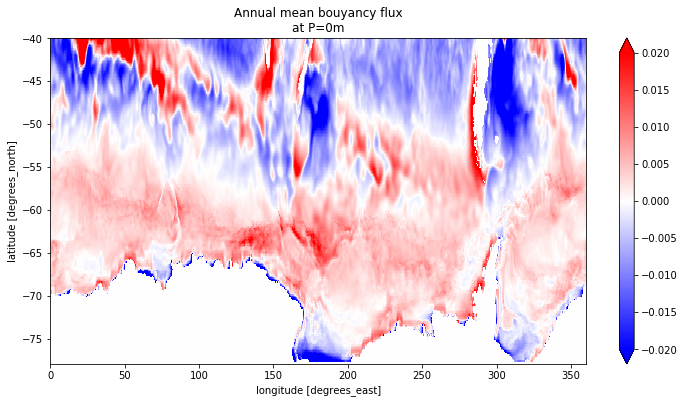

In [28]:
#perhaps it looks different from Ferrari because mine is over 5 years of sose and his is over 3
#but he doesn't specify the yrs he did the avg over
buoyancy_flux_total.sel(YC=slice(-80,-40)).plot(figsize=(12,6), cmap='bwr', vmin=-0.02, vmax=0.02)
plt.title('Annual mean bouyancy flux\nat P=0m');

# Pressure Level 2km

In [29]:
ds_sose.THETA.Z.values

array([-5.0000e+00, -1.5500e+01, -2.7000e+01, -3.9500e+01, -5.3000e+01,
       -6.8000e+01, -8.5000e+01, -1.0400e+02, -1.2550e+02, -1.5000e+02,
       -1.7750e+02, -2.0850e+02, -2.4350e+02, -2.8300e+02, -3.2800e+02,
       -3.7950e+02, -4.3850e+02, -5.0600e+02, -5.8300e+02, -6.7100e+02,
       -7.7200e+02, -8.8800e+02, -1.0210e+03, -1.1735e+03, -1.3485e+03,
       -1.5495e+03, -1.7805e+03, -2.0460e+03, -2.3190e+03, -2.5750e+03,
       -2.8250e+03, -3.0750e+03, -3.3250e+03, -3.5750e+03, -3.8250e+03,
       -4.0750e+03, -4.3250e+03, -4.5750e+03, -4.8250e+03, -5.0750e+03,
       -5.3250e+03, -5.5750e+03], dtype=float32)

In [30]:
sst_2 = ds_sose.THETA.sel(Z=-2e3, method='nearest')
sss_2 = ds_sose.SALT.sel(Z=-2e3, method='nearest')

In [31]:
#lazy mode
#converting practical salinity to absolute salinity
sa_2 = xr.apply_ufunc(gsw.SA_from_SP, sss_2, 2000, ds_sose.XC, ds_sose.YC,
                    output_dtypes=[sss_2.dtype],
                    dask='parallelized').reset_coords(drop=True)
sa_2

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [32]:
#converting potential temperature to conservative temperature
ct_2 = xr.apply_ufunc(gsw.CT_from_pt, sa_2, sst_2,
                    output_dtypes=[sss_2.dtype],
                    dask='parallelized').reset_coords(drop=True)
ct_2

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/gsw/_wrapped_ufuncs.py:644: RuntimeWarning: invalid value encountered in ct_from_pt
  return _gsw_ufuncs.ct_from_pt(SA, pt)


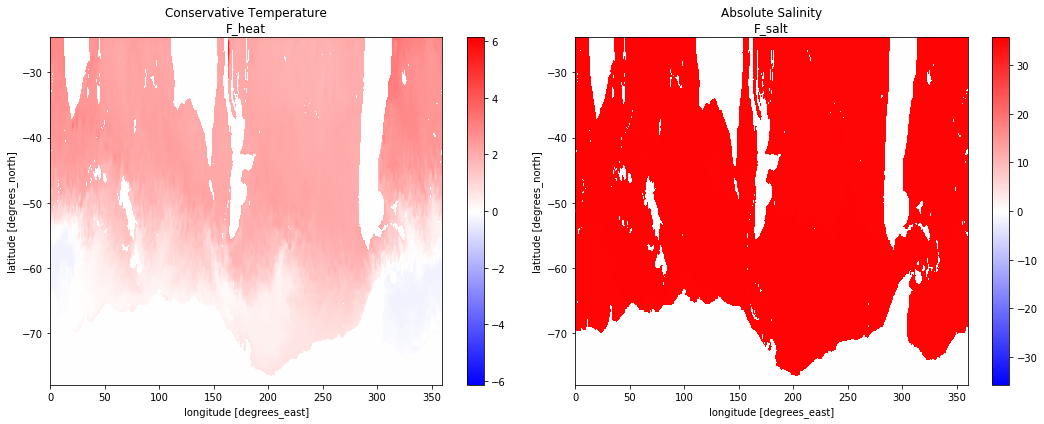

In [33]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15,6))
ct_2[0].plot(ax=ax0, cmap='bwr')
ax0.set_title('Conservative Temperature\nF_heat')
sa_2[0].plot(ax=ax1, cmap='bwr')
ax1.set_title('Absolute Salinity\nF_salt')
plt.tight_layout();

## Compute Density Flux

In [34]:
runit2mass = 1.035e3 #rho_not
heat_capacity_cp = 3.994e3 #J/˚K/kg

### alpha at P=2km

In [35]:
alpha_2 = xr.apply_ufunc(gsw.alpha, sa_2, ct_2, 2000,
                    output_dtypes=[sst_2.dtype],
                    dask='parallelized').reset_coords(drop=True)
alpha_2

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [36]:
a2 = alpha_2[0].load()

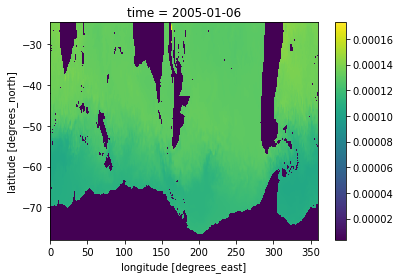

In [37]:
a2.plot()

### beta at P=2km

In [38]:
beta_2 = xr.apply_ufunc(gsw.beta, sa_2, ct_2, 2000,
                      output_dtypes=[sss_2.dtype],
                      dask='parallelized').reset_coords(drop=True)
beta_2

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [39]:
b2 = beta_2[0].load()

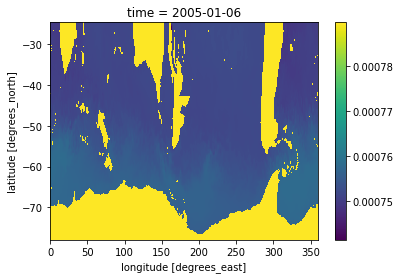

In [40]:
b2.plot()

## Temperature component of F_sigma at 2km

In [41]:
F_sig_heat_2 = (alpha_2 * ds_sose.TFLUX) / heat_capacity_cp
F_sig_heat_2 #kg/m^2/s

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
    rA       (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>

Text(0.5, 1.0, 'temperature component of\ndensity flux\nat t=0')

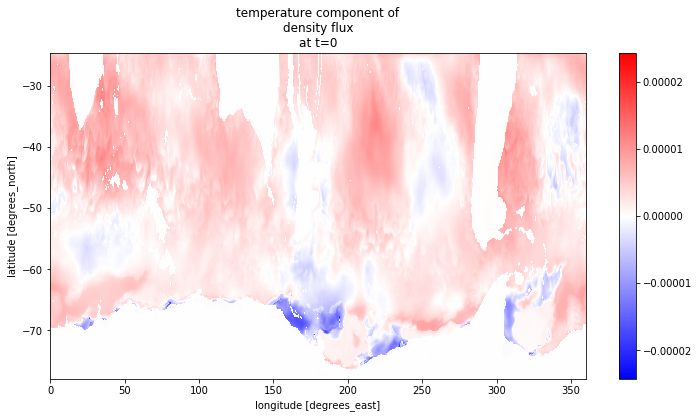

In [42]:
F_sig_heat_2[0].plot(figsize=(12,6), cmap='bwr')
plt.title('temperature component of\ndensity flux\nat t=0')

In [43]:
#temperature annual mean
group_time_heat_2 = F_sig_heat_2.groupby('time.month').mean(dim='time')
ann_mean_heat_2 = group_time_heat_2.mean(dim='month')
ann_mean_heat_2.load()

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (YC: 320, XC: 2160)>
array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [1.080996e-06, 1.079521e-06, 1.077429e-06, ..., 1.065097e-06,
        1.071513e-06, 1.078357e-06],
       [1.130810e-06, 1.130238e-06, 1.129420e-06, ..., 1.110568e-06,
        1.117772e-06, 1.126458e-06],
       [1.161789e-06, 1.161827e-06, 1.161319e-06, ..., 1.140063e-06,
        1.146946e-06, 1.156409e-06]], dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 

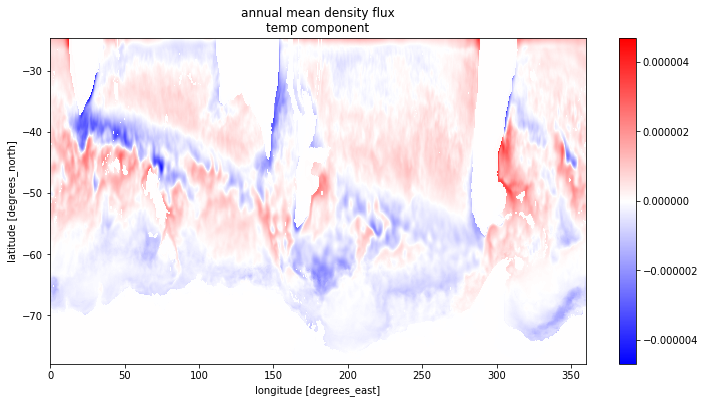

In [44]:
ann_mean_heat_2.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean density flux\ntemp component');

In [45]:
#OFF BY A FACTOR OF 10e-1
#density flux to buoyancy flux -> multiply by (-g/rho_0)
#to get ferrari's mm^2 units *10e6
buoyancy_flux_heat_2 = (ann_mean_heat_2*(-9.81)*10e6) / (10*runit2mass)
buoyancy_flux_heat_2

<xarray.DataArray (YC: 320, XC: 2160)>
array([[-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       ...,
       [-0.010246, -0.010232, -0.010212, ..., -0.010095, -0.010156, -0.010221],
       [-0.010718, -0.010713, -0.010705, ..., -0.010526, -0.010595, -0.010677],
       [-0.011012, -0.011012, -0.011007, ..., -0.010806, -0.010871, -0.010961]],
      dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 ... 311911140.0 311911140.0

Text(0.5, 1.0, 'annual mean buoyancy flux\ntemp component')

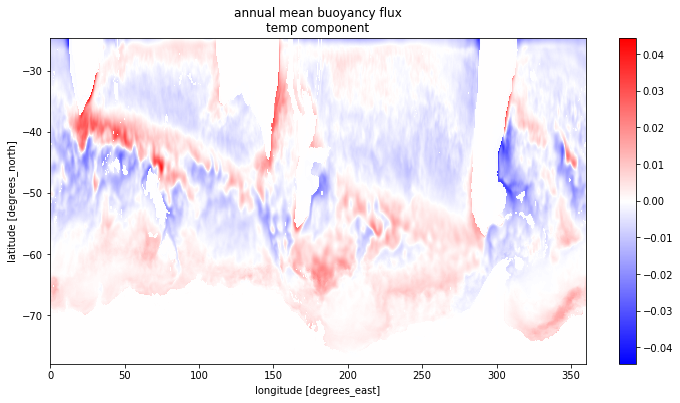

In [46]:
buoyancy_flux_heat_2.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean buoyancy flux\ntemp component')

### Salinity component of F_sigma

$$
F_{\sigma_{salt}} = \beta \frac{(E-P-R)}{\rho_{fw}} = \beta*SFLUX
$$

In [47]:
F_sig_salt_2 = beta_2 * ds_sose.SFLUX
F_sig_salt_2

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
    rA       (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>

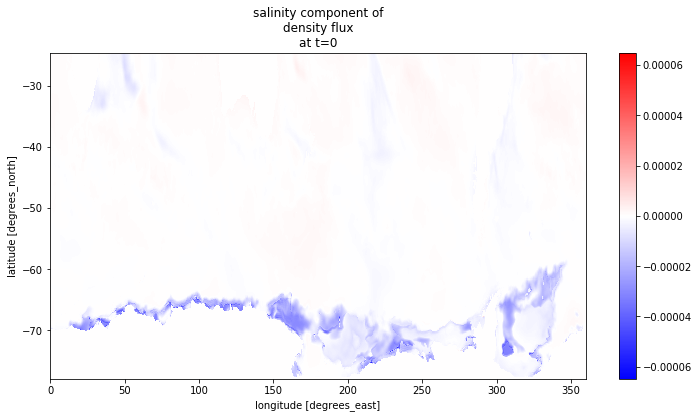

In [48]:
F_sig_salt_2[0].plot(figsize=(12,6), cmap='bwr')
plt.title('salinity component of\ndensity flux\nat t=0');

In [49]:
#temperature annual mean
group_time_salt_2 = F_sig_salt_2.groupby('time.month').mean(dim='time')
ann_mean_salt_2 = group_time_salt_2.mean(dim='month')
ann_mean_salt_2.load()

<xarray.DataArray (YC: 320, XC: 2160)>
array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [1.060496e-06, 1.062198e-06, 1.063498e-06, ..., 1.053454e-06,
        1.055326e-06, 1.057817e-06],
       [1.057935e-06, 1.059279e-06, 1.060366e-06, ..., 1.052225e-06,
        1.053798e-06, 1.055816e-06],
       [1.059399e-06, 1.060608e-06, 1.061769e-06, ..., 1.054489e-06,
        1.055955e-06, 1.057640e-06]], dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 

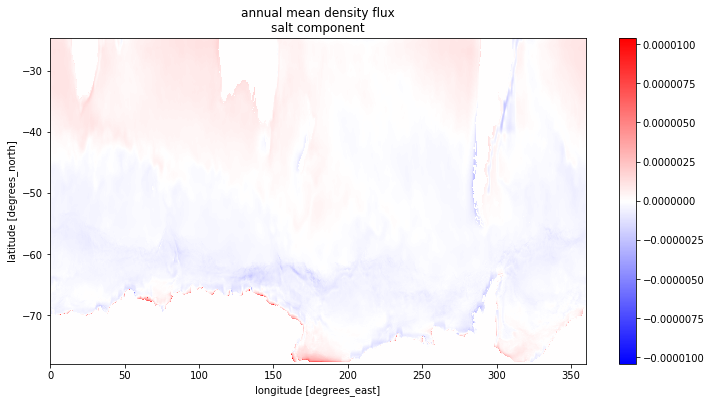

In [50]:
ann_mean_salt_2.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean density flux\nsalt component');

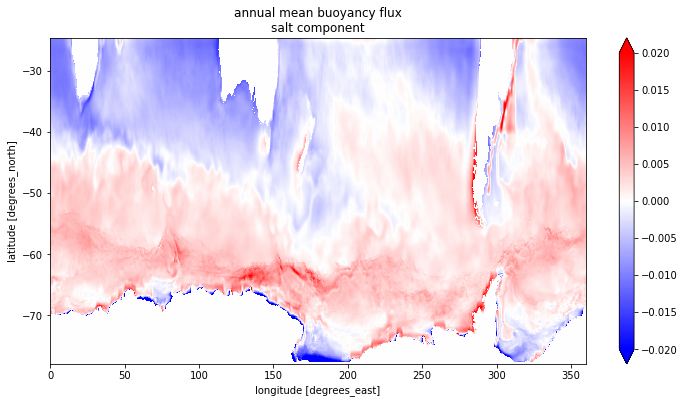

In [122]:
#density flux to buoyancy flux -> multiply by (-g/rho_0)
#to get ferrari's mm^2 units *10e6
buoyancy_flux_salt_2 = ann_mean_salt_2*(-9.81)*10e6/ (10*runit2mass)
buoyancy_flux_salt_2.plot(figsize=(12,6), cmap='bwr', vmin=-0.02, vmax=0.02)
plt.title('annual mean buoyancy flux\nsalt component');

## Total Buoyancy Flux at  reference pressure level 2km $$with\ units\ of\ \frac{mm^{2}}{s^{3}} $$

In [52]:
buoyancy_flux_total_2 = buoyancy_flux_heat_2 + buoyancy_flux_salt_2
buoyancy_flux_total_2

<xarray.DataArray (YC: 320, XC: 2160)>
array([[-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       ...,
       [-0.020298, -0.0203  , -0.020292, ..., -0.02008 , -0.020159, -0.020247],
       [-0.020745, -0.020753, -0.020755, ..., -0.0205  , -0.020583, -0.020684],
       [-0.021053, -0.021065, -0.021071, ..., -0.020801, -0.02088 , -0.020985]],
      dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 ... 311911140.0 311911140.0

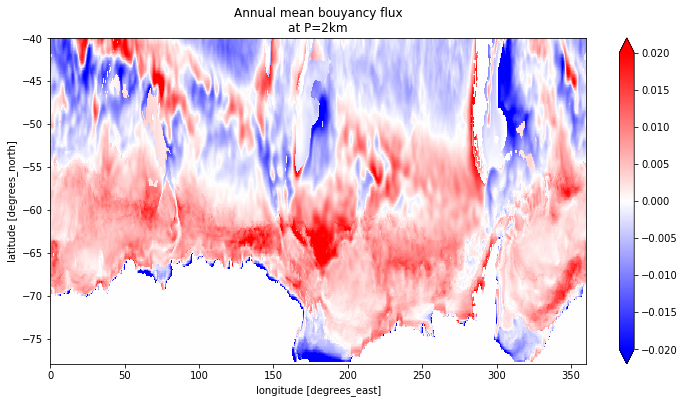

In [108]:
#perhaps it looks different from Ferrari because mine is over 5 years of sose and his is over 3
#but he doesn't specify the yrs he did the avg over
buoyancy_flux_total_2.sel(YC=slice(-80,-40)).plot(figsize=(12,6), cmap='bwr', vmin=-0.02, vmax=0.02)
plt.title('Annual mean bouyancy flux\nat P=2km');

# Pressure Level 3km

In [54]:
sst_3 = ds_sose.THETA.sel(Z=-3e3, method='nearest')
sss_3 = ds_sose.SALT.sel(Z=-3e3, method='nearest')

In [55]:
#lazy mode
#converting practical salinity to absolute salinity
sa_3 = xr.apply_ufunc(gsw.SA_from_SP, sss_3, 3000, ds_sose.XC, ds_sose.YC,
                    output_dtypes=[sss_3.dtype],
                    dask='parallelized').reset_coords(drop=True)
sa_3

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [56]:
#converting potential temperature to conservative temperature
ct_3 = xr.apply_ufunc(gsw.CT_from_pt, sa_3, sst_3,
                    output_dtypes=[sss_3.dtype],
                    dask='parallelized').reset_coords(drop=True)
ct_3

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/gsw/_wrapped_ufuncs.py:644: RuntimeWarning: invalid value encountered in ct_from_pt
  return _gsw_ufuncs.ct_from_pt(SA, pt)


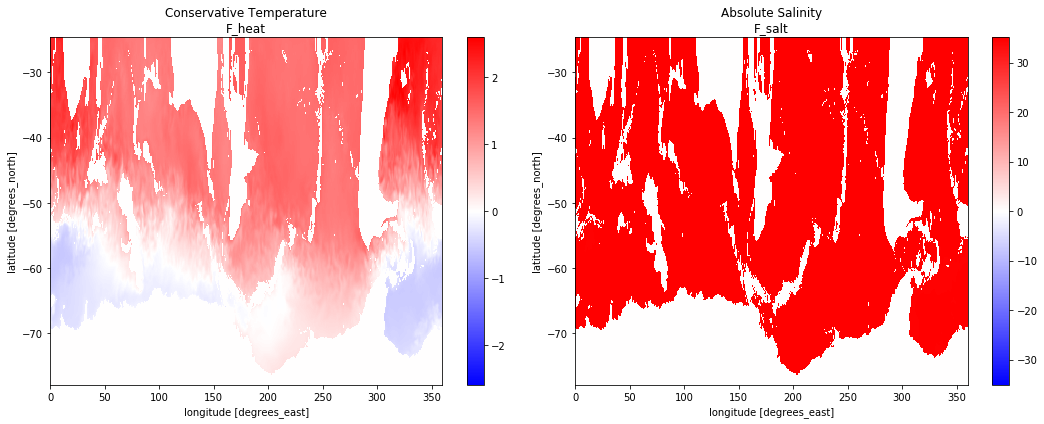

In [57]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15,6))
ct_3[0].plot(ax=ax0, cmap='bwr')
ax0.set_title('Conservative Temperature\nF_heat')
sa_3[0].plot(ax=ax1, cmap='bwr')
ax1.set_title('Absolute Salinity\nF_salt')
plt.tight_layout();

## Compute Density Flux

In [58]:
runit2mass = 1.035e3 #rho_not
heat_capacity_cp = 3.994e3 #J/˚K/kg

### alpha at P=3km

In [59]:
alpha_3 = xr.apply_ufunc(gsw.alpha, sa_3, ct_3, 3000,
                    output_dtypes=[sst_3.dtype],
                    dask='parallelized').reset_coords(drop=True)
alpha_3

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [60]:
a3 = alpha_3[0].load()

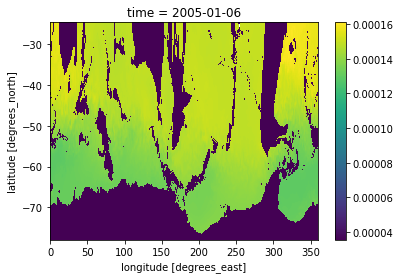

In [61]:
a3.plot()

### beta at P=3km

In [62]:
beta_3 = xr.apply_ufunc(gsw.beta, sa_3, ct_3, 3000,
                      output_dtypes=[sss_3.dtype],
                      dask='parallelized').reset_coords(drop=True)
beta_3

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [63]:
b3 = beta_3[0].load()

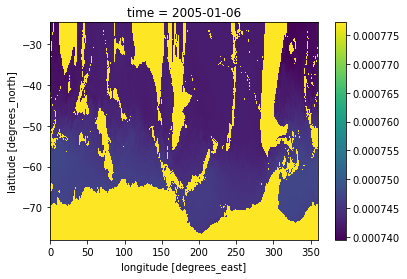

In [64]:
b3.plot()

## Temperature component of F_sigma at 3km

In [65]:
F_sig_heat_3 = (alpha_3 * ds_sose.TFLUX) / heat_capacity_cp
F_sig_heat_3 #kg/m^2/s

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
    rA       (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>

Text(0.5, 1.0, 'temperature component of\ndensity flux\nat t=0')

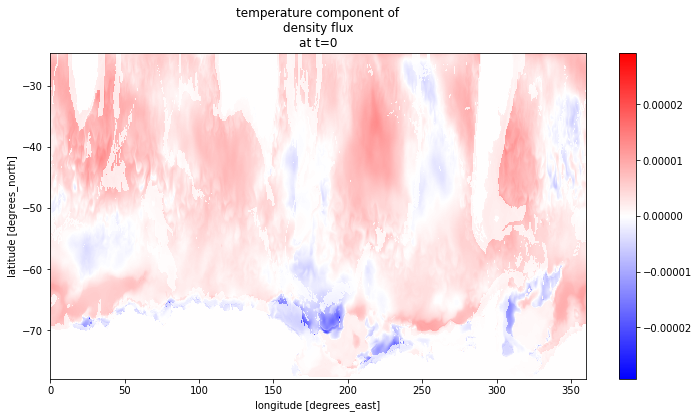

In [66]:
F_sig_heat_3[0].plot(figsize=(12,6), cmap='bwr')
plt.title('temperature component of\ndensity flux\nat t=0')

In [67]:
#temperature annual mean
group_time_heat_3 = F_sig_heat_3.groupby('time.month').mean(dim='time')
ann_mean_heat_3 = group_time_heat_3.mean(dim='month')
ann_mean_heat_3.load()

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (YC: 320, XC: 2160)>
array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [1.226943e-06, 1.224995e-06, 1.222345e-06, ..., 1.209701e-06,
        1.216727e-06, 1.224222e-06],
       [1.283456e-06, 1.282518e-06, 1.281296e-06, ..., 1.261310e-06,
        1.269223e-06, 1.278803e-06],
       [1.319084e-06, 1.318848e-06, 1.317992e-06, ..., 1.295247e-06,
        1.302786e-06, 1.313255e-06]], dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 

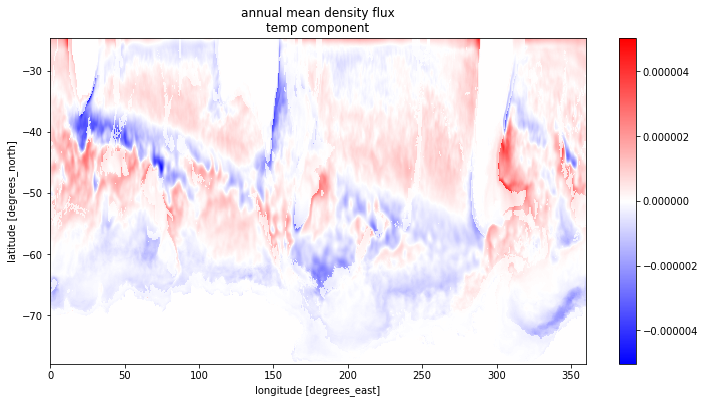

In [68]:
ann_mean_heat_3.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean density flux\ntemp component');

In [69]:
#OFF BY A FACTOR OF 10e-1
#density flux to buoyancy flux -> multiply by (-g/rho_0)
#to get ferrari's mm^2 units *10e6
buoyancy_flux_heat_3 = (ann_mean_heat_3*(-9.81)*10e6) / (10*runit2mass)
buoyancy_flux_heat_3

<xarray.DataArray (YC: 320, XC: 2160)>
array([[-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       ...,
       [-0.011629, -0.011611, -0.011586, ..., -0.011466, -0.011532, -0.011603],
       [-0.012165, -0.012156, -0.012144, ..., -0.011955, -0.01203 , -0.012121],
       [-0.012503, -0.0125  , -0.012492, ..., -0.012277, -0.012348, -0.012447]],
      dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 ... 311911140.0 311911140.0

Text(0.5, 1.0, 'annual mean buoyancy flux\ntemp component')

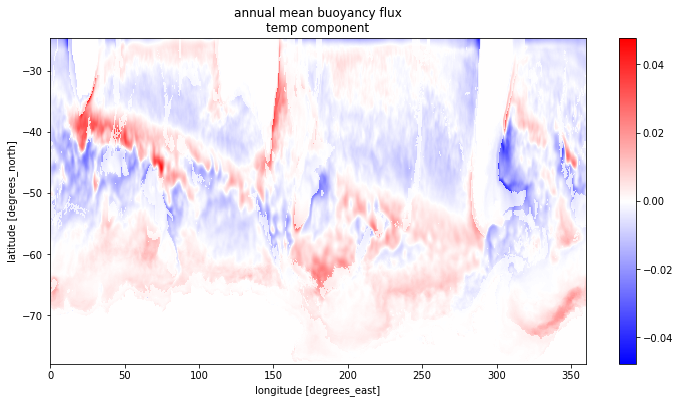

In [70]:
buoyancy_flux_heat_3.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean buoyancy flux\ntemp component')

### Salinity component of F_sigma

$$
F_{\sigma_{salt}} = \beta \frac{(E-P-R)}{\rho_{fw}} = \beta*SFLUX
$$

In [71]:
F_sig_salt_3 = beta_3 * ds_sose.SFLUX
F_sig_salt_3

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
    rA       (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>

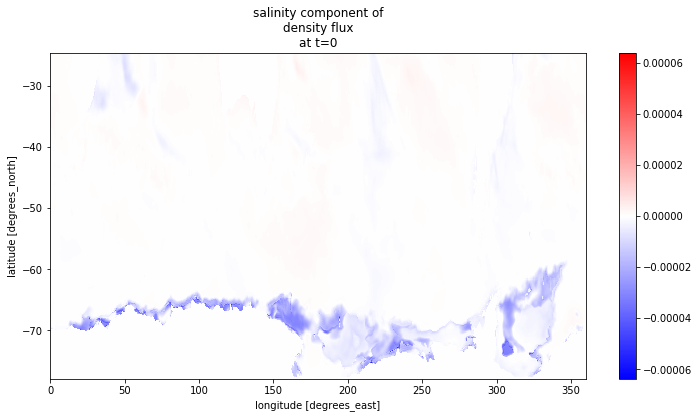

In [72]:
F_sig_salt_3[0].plot(figsize=(12,6), cmap='bwr')
plt.title('salinity component of\ndensity flux\nat t=0');

In [73]:
#temperature annual mean
group_time_salt_3 = F_sig_salt_3.groupby('time.month').mean(dim='time')
ann_mean_salt_3 = group_time_salt_3.mean(dim='month')
ann_mean_salt_3.load()

<xarray.DataArray (YC: 320, XC: 2160)>
array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [1.047245e-06, 1.048936e-06, 1.050229e-06, ..., 1.040261e-06,
        1.042120e-06, 1.044590e-06],
       [1.044718e-06, 1.046056e-06, 1.047139e-06, ..., 1.039050e-06,
        1.040614e-06, 1.042616e-06],
       [1.046147e-06, 1.047351e-06, 1.048507e-06, ..., 1.041270e-06,
        1.042727e-06, 1.044401e-06]], dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 

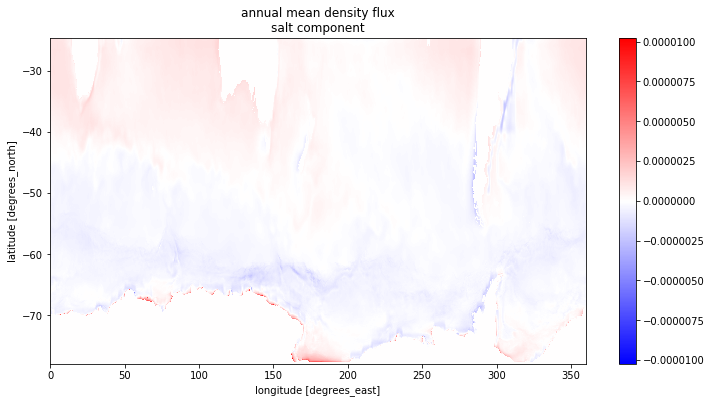

In [74]:
ann_mean_salt_3.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean density flux\nsalt component');

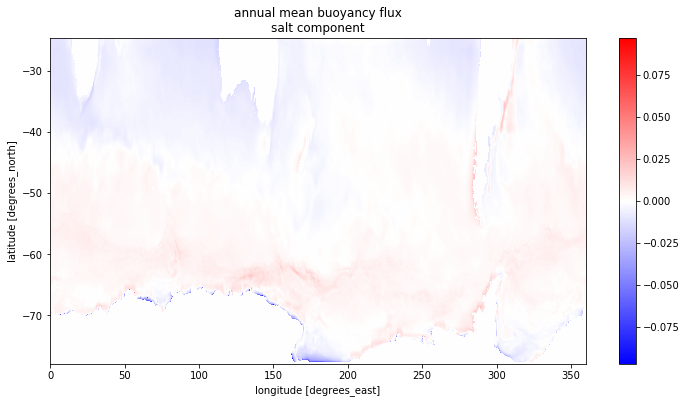

In [75]:
#density flux to buoyancy flux -> multiply by (-g/rho_0)
#to get ferrari's mm^2 units *10e6
buoyancy_flux_salt_3 = ann_mean_salt_3*(-9.81)*10e6/ (10*runit2mass)
buoyancy_flux_salt_3.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean buoyancy flux\nsalt component');

## Total Buoyancy Flux at reference pressure 3km $$with\ units\ of\ \frac{mm^{2}}{s^{3}} $$

In [76]:
buoyancy_flux_total_3 = buoyancy_flux_heat_3 + buoyancy_flux_salt_3
buoyancy_flux_total_3

<xarray.DataArray (YC: 320, XC: 2160)>
array([[-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       ...,
       [-0.021555, -0.021553, -0.02154 , ..., -0.021326, -0.02141 , -0.021504],
       [-0.022067, -0.022071, -0.02207 , ..., -0.021803, -0.021893, -0.022003],
       [-0.022418, -0.022427, -0.02243 , ..., -0.022146, -0.022231, -0.022346]],
      dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 ... 311911140.0 311911140.0

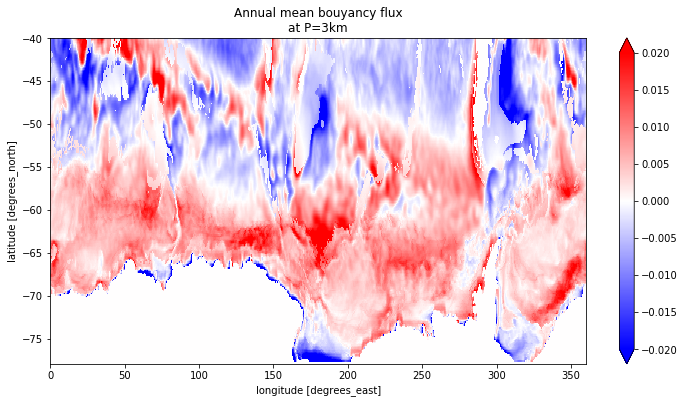

In [106]:
#perhaps it looks different from Ferrari because mine is over 5 years of sose and his is over 3
#but he doesn't specify the yrs he did the avg over
buoyancy_flux_total_3.sel(YC=slice(-80,-40)).plot(figsize=(12,6), cmap='bwr', vmin=-0.02, vmax=0.02)
plt.title('Annual mean bouyancy flux\nat P=3km');

# Pressure Level 4km

In [78]:
sst_4 = ds_sose.THETA.sel(Z=-4e3, method='nearest')
sss_4 = ds_sose.SALT.sel(Z=-4e3, method='nearest')

In [79]:
#lazy mode
#converting practical salinity to absolute salinity
sa_4 = xr.apply_ufunc(gsw.SA_from_SP, sss_4, 4000, ds_sose.XC, ds_sose.YC,
                    output_dtypes=[sss_4.dtype],
                    dask='parallelized').reset_coords(drop=True)
sa_4

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [80]:
#converting potential temperature to conservative temperature
ct_4 = xr.apply_ufunc(gsw.CT_from_pt, sa_4, sst_4,
                    output_dtypes=[sss_4.dtype],
                    dask='parallelized').reset_coords(drop=True)
ct_4

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/gsw/_wrapped_ufuncs.py:644: RuntimeWarning: invalid value encountered in ct_from_pt
  return _gsw_ufuncs.ct_from_pt(SA, pt)


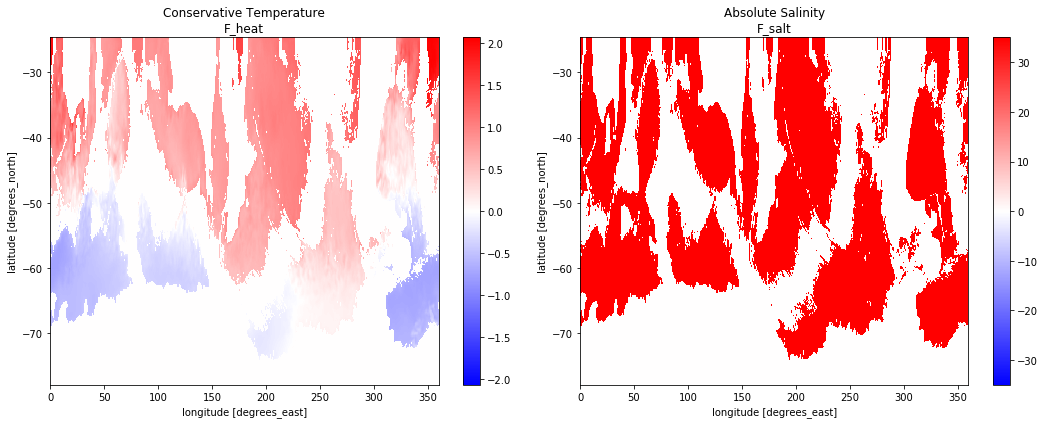

In [81]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15,6))
ct_4[0].plot(ax=ax0, cmap='bwr')
ax0.set_title('Conservative Temperature\nF_heat')
sa_4[0].plot(ax=ax1, cmap='bwr')
ax1.set_title('Absolute Salinity\nF_salt')
plt.tight_layout();

## Compute Density Flux

In [82]:
runit2mass = 1.035e3 #rho_not
heat_capacity_cp = 3.994e3 #J/˚K/kg

### alpha at P=4km

In [83]:
alpha_4 = xr.apply_ufunc(gsw.alpha, sa_4, ct_4, 4000,
                    output_dtypes=[sst_4.dtype],
                    dask='parallelized').reset_coords(drop=True)
alpha_4

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [84]:
a4 = alpha_4[0].load()

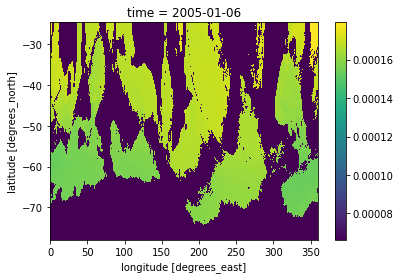

In [85]:
a4.plot()

### beta at P=4km

In [86]:
beta_4 = xr.apply_ufunc(gsw.beta, sa_4, ct_4, 4000,
                      output_dtypes=[sss_4.dtype],
                      dask='parallelized').reset_coords(drop=True)
beta_4

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [87]:
b4 = beta_4[0].load()

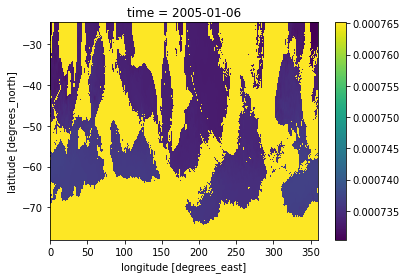

In [88]:
b4.plot()

## Temperature component of F_sigma at 4km

In [89]:
F_sig_heat_4 = (alpha_4 * ds_sose.TFLUX) / heat_capacity_cp
F_sig_heat_4 #kg/m^2/s

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
    rA       (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>

Text(0.5, 1.0, 'temperature component of\ndensity flux\nat t=0')

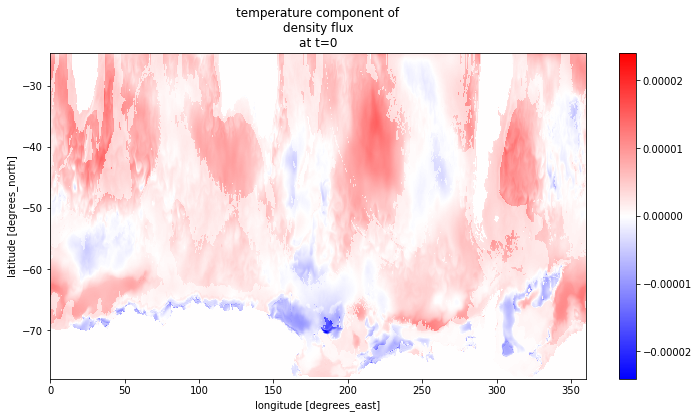

In [90]:
F_sig_heat_4[0].plot(figsize=(12,6), cmap='bwr')
plt.title('temperature component of\ndensity flux\nat t=0')

In [91]:
#temperature annual mean
group_time_heat_4 = F_sig_heat_4.groupby('time.month').mean(dim='time')
ann_mean_heat_4 = group_time_heat_4.mean(dim='month')
ann_mean_heat_4.load()

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (YC: 320, XC: 2160)>
array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [1.400608e-06, 1.398369e-06, 1.395323e-06, ..., 1.380984e-06,
        1.388988e-06, 1.397515e-06],
       [1.465105e-06, 1.464021e-06, 1.462609e-06, ..., 1.439884e-06,
        1.448901e-06, 1.459810e-06],
       [1.505875e-06, 1.505596e-06, 1.504606e-06, ..., 1.478702e-06,
        1.487295e-06, 1.499233e-06]], dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 

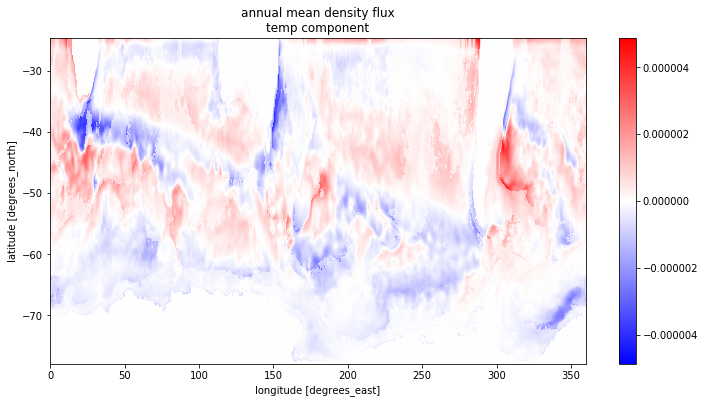

In [92]:
ann_mean_heat_4.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean density flux\ntemp component');

In [93]:
#OFF BY A FACTOR OF 10e-1
#density flux to buoyancy flux -> multiply by (-g/rho_0)
#to get ferrari's mm^2 units *10e6
buoyancy_flux_heat_4 = (ann_mean_heat_4*(-9.81)*10e6) / (10*runit2mass)
buoyancy_flux_heat_4

<xarray.DataArray (YC: 320, XC: 2160)>
array([[-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       ...,
       [-0.013275, -0.013254, -0.013225, ..., -0.013089, -0.013165, -0.013246],
       [-0.013887, -0.013876, -0.013863, ..., -0.013648, -0.013733, -0.013836],
       [-0.014273, -0.01427 , -0.014261, ..., -0.014016, -0.014097, -0.01421 ]],
      dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 ... 311911140.0 311911140.0

Text(0.5, 1.0, 'annual mean buoyancy flux\ntemp component')

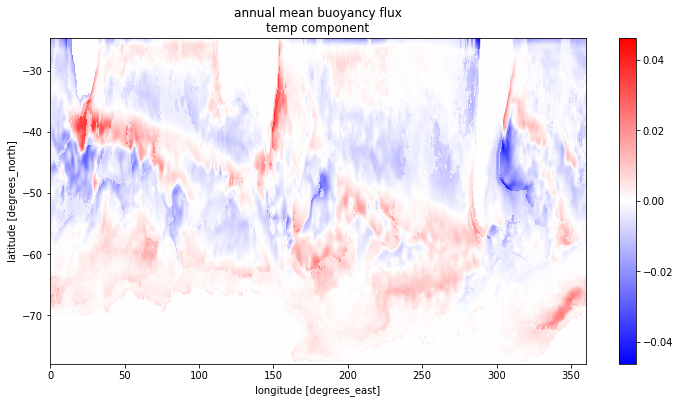

In [94]:
buoyancy_flux_heat_4.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean buoyancy flux\ntemp component')

### Salinity component of F_sigma

$$
F_{\sigma_{salt}} = \beta \frac{(E-P-R)}{\rho_{fw}} = \beta*SFLUX
$$

In [95]:
F_sig_salt_4 = beta_4 * ds_sose.SFLUX
F_sig_salt_4

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
    rA       (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>

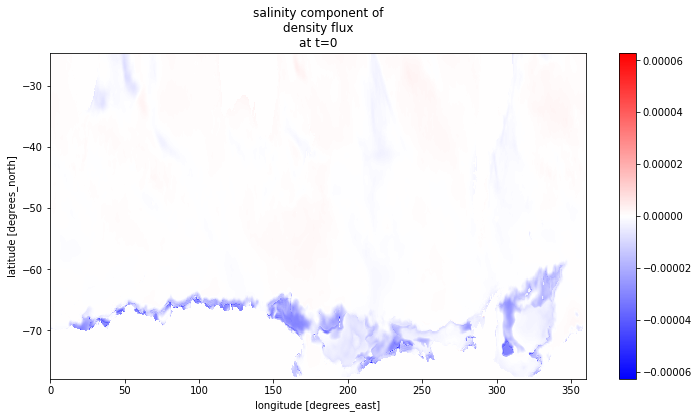

In [96]:
F_sig_salt_4[0].plot(figsize=(12,6), cmap='bwr')
plt.title('salinity component of\ndensity flux\nat t=0');

In [97]:
#temperature annual mean
group_time_salt_4 = F_sig_salt_4.groupby('time.month').mean(dim='time')
ann_mean_salt_4 = group_time_salt_4.mean(dim='month')
ann_mean_salt_4.load()

<xarray.DataArray (YC: 320, XC: 2160)>
array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [1.032961e-06, 1.034630e-06, 1.035908e-06, ..., 1.026068e-06,
        1.027902e-06, 1.030341e-06],
       [1.030469e-06, 1.031789e-06, 1.032859e-06, ..., 1.024873e-06,
        1.026417e-06, 1.028394e-06],
       [1.031875e-06, 1.033064e-06, 1.034206e-06, ..., 1.027060e-06,
        1.028499e-06, 1.030151e-06]], dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 

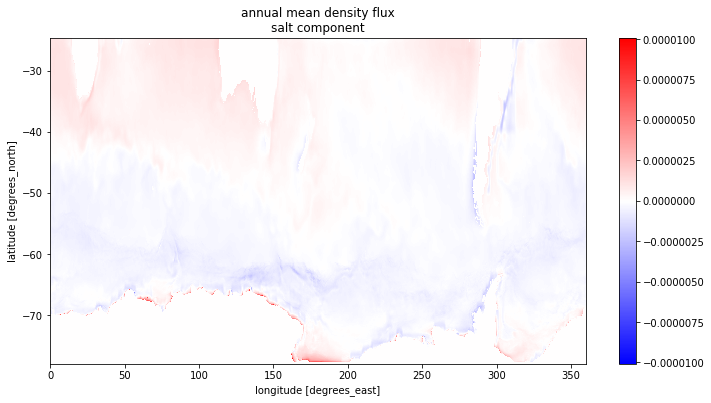

In [98]:
ann_mean_salt_4.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean density flux\nsalt component');

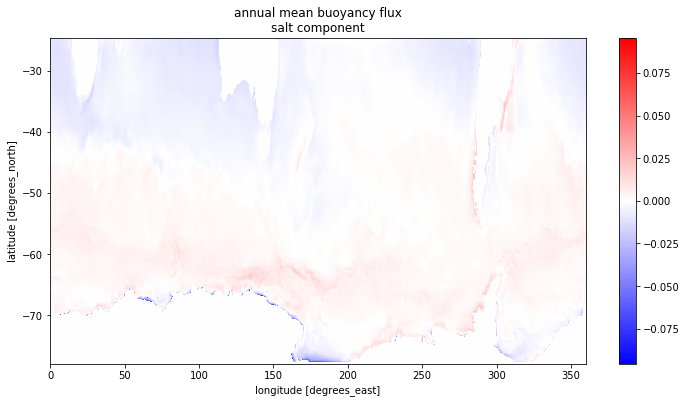

In [99]:
#density flux to buoyancy flux -> multiply by (-g/rho_0)
#to get ferrari's mm^2 units *10e6
buoyancy_flux_salt_4 = ann_mean_salt_4*(-9.81)*10e6/ (10*runit2mass)
buoyancy_flux_salt_4.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean buoyancy flux\nsalt component');

## Total Buoyancy Flux at different pressure 4km $$with\ units\ of\ \frac{mm^{2}}{s^{3}} $$

In [100]:
buoyancy_flux_total_4 = buoyancy_flux_heat_4 + buoyancy_flux_salt_4
buoyancy_flux_total_4

<xarray.DataArray (YC: 320, XC: 2160)>
array([[-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       ...,
       [-0.023066, -0.023061, -0.023044, ..., -0.022815, -0.022908, -0.023012],
       [-0.023654, -0.023656, -0.023653, ..., -0.023362, -0.023462, -0.023584],
       [-0.024053, -0.024062, -0.024064, ..., -0.02375 , -0.023845, -0.023974]],
      dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 ... 311911140.0 311911140.0

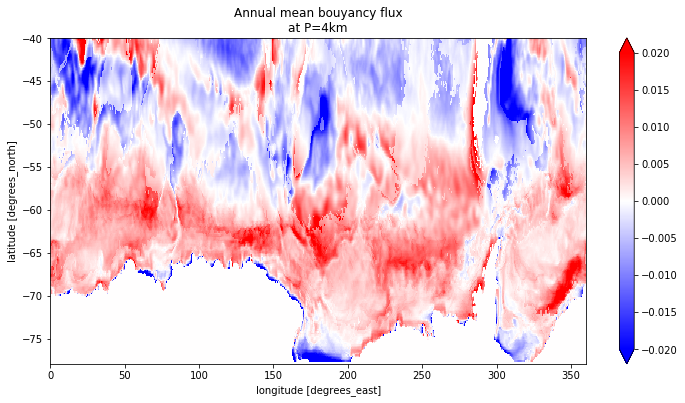

In [104]:
#perhaps it looks different from Ferrari because mine is over 5 years of sose and his is over 3
#but he doesn't specify the yrs he did the avg over
buoyancy_flux_total_4.sel(YC=slice(-80,-40)).plot(figsize=(12,6), cmap='bwr', vmin=-0.02, vmax=0.02)
plt.title('Annual mean bouyancy flux\nat P=4km');

# Compilation of T/S buoyancy fluxes at the 4 different reference levels

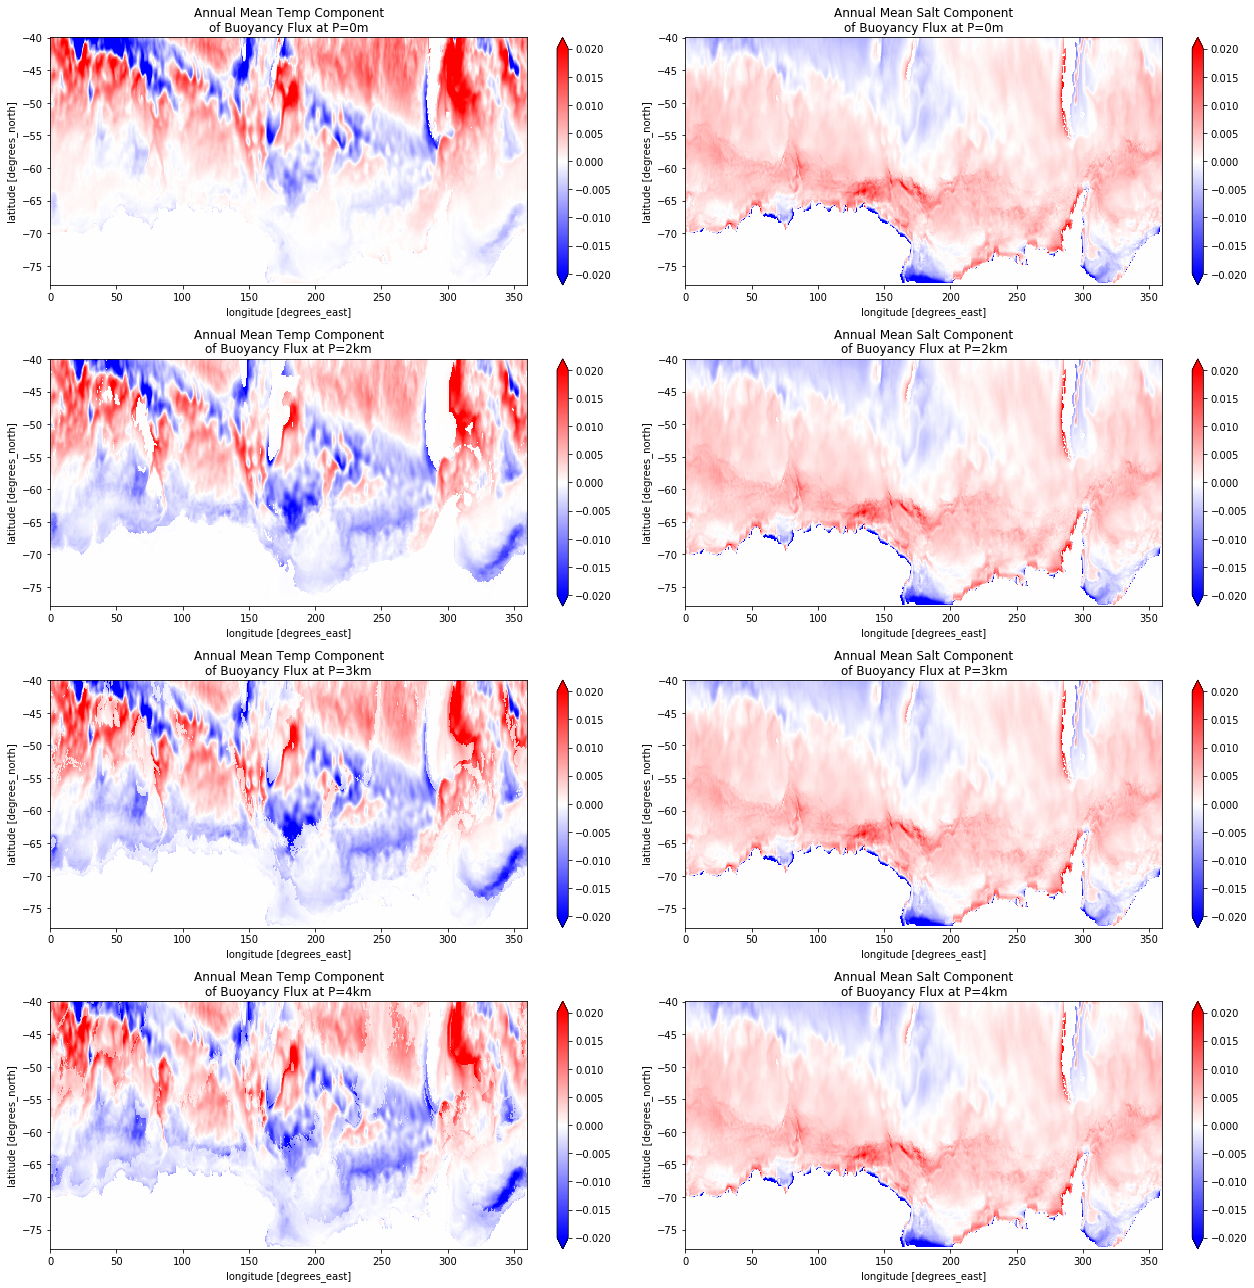

In [132]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(18,18))#, sharex=True, sharey=True)

(-buoyancy_flux_heat).sel(YC=slice(-80,-40)).plot(ax=axes[0,0], cmap='bwr', vmin=-0.02, vmax=0.02)
axes[0,0].set_title('Annual Mean Temp Component\nof Buoyancy Flux at P=0m')
buoyancy_flux_salt.sel(YC=slice(-80,-40)).plot(ax=axes[0,1], cmap='bwr', vmin=-0.02, vmax=0.02)
axes[0,1].set_title('Annual Mean Salt Component\nof Buoyancy Flux at P=0m')

(-buoyancy_flux_heat_2).sel(YC=slice(-80,-40)).plot(ax=axes[1,0], cmap='bwr', vmin=-0.02, vmax=0.02)
axes[1,0].set_title('Annual Mean Temp Component\nof Buoyancy Flux at P=2km')
buoyancy_flux_salt_2.sel(YC=slice(-80,-40)).plot(ax=axes[1,1], cmap='bwr', vmin=-0.02, vmax=0.02)
axes[1,1].set_title('Annual Mean Salt Component\nof Buoyancy Flux at P=2km')

(-buoyancy_flux_heat_3).sel(YC=slice(-80,-40)).plot(ax=axes[2,0], cmap='bwr', vmin=-0.02, vmax=0.02)
axes[2,0].set_title('Annual Mean Temp Component\nof Buoyancy Flux at P=3km')
buoyancy_flux_salt_3.sel(YC=slice(-80,-40)).plot(ax=axes[2,1], cmap='bwr', vmin=-0.02, vmax=0.02)
axes[2,1].set_title('Annual Mean Salt Component\nof Buoyancy Flux at P=3km')

(-buoyancy_flux_heat_4).sel(YC=slice(-80,-40)).plot(ax=axes[3,0], cmap='bwr', vmin=-0.02, vmax=0.02)
axes[3,0].set_title('Annual Mean Temp Component\nof Buoyancy Flux at P=4km')
buoyancy_flux_salt_4.sel(YC=slice(-80,-40)).plot(ax=axes[3,1], cmap='bwr', vmin=-0.02, vmax=0.02)
axes[3,1].set_title('Annual Mean Salt Component\nof Buoyancy Flux at P=4km')

plt.tight_layout();

In [147]:
zonal_mean_temp0 = (-buoyancy_flux_heat).mean(dim='XC').sel(YC=slice(-80,-40))
zonal_mean_temp2 = (-buoyancy_flux_heat_2).mean(dim='XC').sel(YC=slice(-80,-40))
zonal_mean_temp3 = (-buoyancy_flux_heat_3).mean(dim='XC').sel(YC=slice(-80,-40))
zonal_mean_temp4 = (-buoyancy_flux_heat_4).mean(dim='XC').sel(YC=slice(-80,-40))

zonal_mean_salt0 = buoyancy_flux_salt.mean(dim='XC').sel(YC=slice(-80,-40))
zonal_mean_salt2 = buoyancy_flux_salt_2.mean(dim='XC').sel(YC=slice(-80,-40))
zonal_mean_salt3 = buoyancy_flux_salt_3.mean(dim='XC').sel(YC=slice(-80,-40))
zonal_mean_salt4 = buoyancy_flux_salt_4.mean(dim='XC').sel(YC=slice(-80,-40))

In [149]:
zonal_mean = xr.merge([zonal_mean_temp0.to_dataset(name='zonal_mean_temp0'),
                       zonal_mean_temp2.to_dataset(name='zonal_mean_temp2'),
                       zonal_mean_temp3.to_dataset(name='zonal_mean_temp3'),
                       zonal_mean_temp4.to_dataset(name='zonal_mean_temp4'),
                       zonal_mean_salt0.to_dataset(name='zonal_mean_salt0'),
                       zonal_mean_salt2.to_dataset(name='zonal_mean_salt2'),
                       zonal_mean_salt3.to_dataset(name='zonal_mean_salt3'),
                       zonal_mean_salt4.to_dataset(name='zonal_mean_salt4')])
zonal_mean

<xarray.Dataset>
Dimensions:           (YC: 228)
Coordinates:
  * YC                (YC) float32 -77.87497 -77.7083 ... -40.208298 -40.041634
Data variables:
    zonal_mean_temp0  (YC) float32 0.0 0.0 ... -0.00060188153 -0.0009669379
    zonal_mean_temp2  (YC) float32 0.0 0.0 ... -0.00050809805 -0.00070931384
    zonal_mean_temp3  (YC) float32 0.0 0.0 ... -0.00015473212 -0.0003885734
    zonal_mean_temp4  (YC) float32 0.0 0.0 ... -3.0939445e-05 -0.00024970228
    zonal_mean_salt0  (YC) float32 0.0 0.0 ... -0.0018266038 -0.0018901128
    zonal_mean_salt2  (YC) float32 0.0 0.0 ... -0.0018599639 -0.0019247329
    zonal_mean_salt3  (YC) float32 0.0 0.0 ... -0.0018459219 -0.0019096783
    zonal_mean_salt4  (YC) float32 0.0 0.0 ... -0.0018405494 -0.0019043928

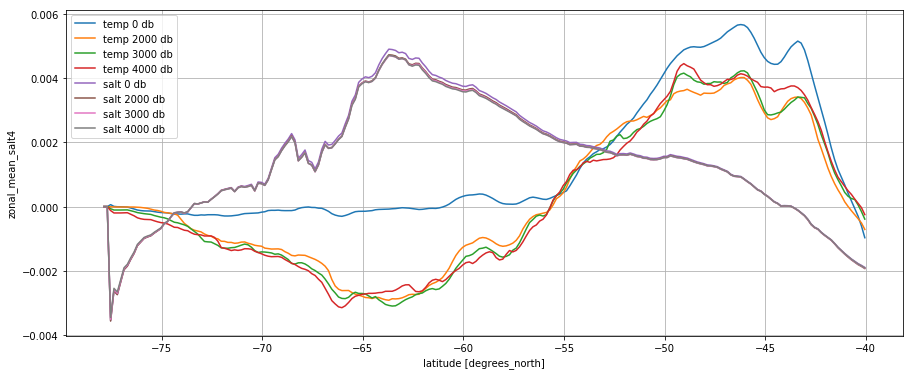

In [151]:
plt.figure(figsize=(15, 6))

zonal_mean.zonal_mean_temp0.plot(label='temp 0 db')
zonal_mean.zonal_mean_temp2.plot(label='temp 2000 db')
zonal_mean.zonal_mean_temp3.plot(label='temp 3000 db')
zonal_mean.zonal_mean_temp4.plot(label='temp 4000 db')
zonal_mean.zonal_mean_salt0.plot(label='salt 0 db')
zonal_mean.zonal_mean_salt2.plot(label='salt 2000 db')
zonal_mean.zonal_mean_salt3.plot(label='salt 3000 db')
zonal_mean.zonal_mean_salt4.plot(label='salt 4000 db')
plt.legend()
plt.grid()

In [ ]:
plt.figure(figsize=(15, 6))
for dvar in zonal_mean.data_vars:
    zonal_mean[dvar].plot()
plt.xlim('1982', '2018')
plt.legend()
plt.grid()
plt.axhline(y=0)
plt.title('Anomaly of wind stress curl (monthly)\n30˚W-30˚E,70˚-60˚S', fontsize=16)
plt.ylabel('curl tau $10^{-8}$ N/$m^{3}$');

No handles with labels found to put in legend.


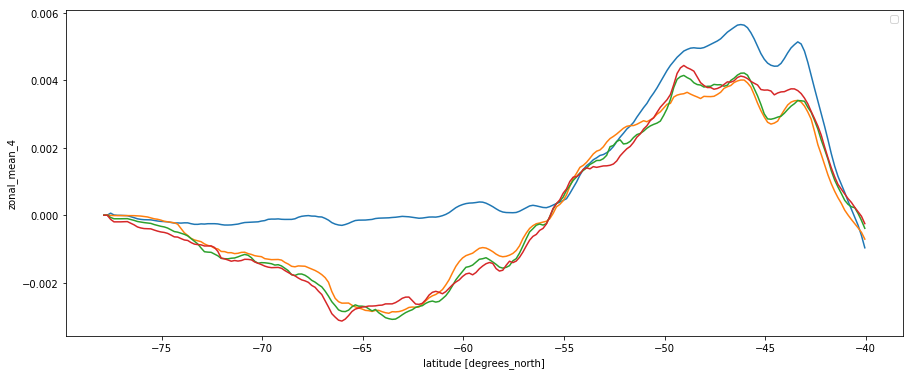

In [142]:
plt.figure(figsize=(15,6))
for dvar in zonal_mean.data_vars:
    zonal_mean[dvar].plot()
plt.legend()

# Past Efforts below for trying what is achieved above
Best not to delete these so that you can look back on your though process and see the progression

In [ ]:
F_sigma_p0 = F_sig_heat + F_sig_salt
F_sigma_p0

In [ ]:
F_sigma_p0[0].plot(cmap='bwr')

In [ ]:
ds_sose.SFLUX.units

In [ ]:
ds_sose.TFLUX.long_name

In [ ]:
print(ds_sose.SFLUX, ds_sose.TFLUX)

$$
F_{\sigma} = F_{heat}\frac{\partial\sigma}{\partial\theta} + F_{salt}\frac{\partial\sigma}{\partial S}\
$$

$$
where
$$

$$
F_{heat} = \frac{\partial \theta}{\partial t}\ is\ the\ heat\ flux
$$

$$
F_{salt} = \frac{\partial \theta}{\partial t}\ is\ the\ salt\ flux
$$

$$
where\ \frac{\partial\sigma}{\partial\theta} \sim \alpha = -\frac{1}{\rho_0}\frac{\partial\rho}{\partial\theta}\ is\ the\ thermal\ expansion\ coefficient
$$

$$
where\ \frac{\partial\sigma}{\partial S} \sim \beta = \frac{1}{\rho_0}\frac{\partial\rho}{\partial S}\ is\ the\ haline\ contraction\ coefficient 
$$

In [ ]:
#multiply by another rho because of definition of rho
F_sigma = (ds_sose.TFLUX / (runit2mass*heat_capacity_cp))*alpha + (ds_sose.SFLUX / runit2mass)*beta
F_sigma

In [ ]:
F_sigma['time']

In [ ]:
F_sigma.time

In [ ]:
ds_sose.TFLUX

In [ ]:
group_time = F_sigma.groupby('time.month').mean(dim='time')
group_time

In [ ]:
with ProgressBar():
    ann_mean = group_time.mean(dim='month')
    ann_mean.load()

In [ ]:
ann_mean.plot()
plt.title('density flux\nunits: kg/m^2/s')

1. So from here try to first convert this density flux map to buoyancy flux by multiplying it by g/rho
2. then convert m^2 to mm^2
3. See if this matches Ferrari's figure 3 and then if it does change pressure to 3 other reference pressures then see how they change!

In [ ]:
#to go from density flux to buoyancy flux multiply by (-g/rho)
ferrari = ann_mean*(-9.81/1035)*10e6
ferrari

In [ ]:
#still off by a factor of 100 - maybe that comes from the g to kg conversion for SFLUX term in F_sigma?
#colors seem inverted
(100*ferrari).sel(YC=slice(-80,-40)).plot(figsize=(15,7), cmap='bwr', vmin=-0.02, vmax=0.02)
#plt.pcolormesh(edgecolors='white')
plt.title('Ferrari Fig.3 of Annual Mean Buoyancy Flux\nP=0');

In [ ]:
#For ECCO Model
cat = intake.Catalog('https://raw.githubusercontent.com/pangeo-data/pangeo_ocean_examples/master/catalog.yaml')
ds_ecco = cat.ECCOv4r3.to_dask()
#ds_ecco

In [ ]:
#For SOSE Model
cat = intake.Catalog('https://raw.githubusercontent.com/pangeo-data/pangeo_ocean_examples/master/catalog.yaml')
ds = cat.SOSE.to_dask()
ds

In [ ]:
#to make things more efficient only pull the variables you want to work with
vars_i_want = ['SFLUX', 'TFLUX', 'SALT', 'THETA']
my_ds = ds[vars_i_want].isel(Z=0)
my_ds

In [ ]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    my_ds.load()

In [ ]:
my_ds.nbytes/1e9

In [ ]:
ds.XG

In [ ]:
for vname in ds.data_vars:
    print(vname, ds[vname].attrs["long_name"], ds[vname].attrs["units"])

In [ ]:
ds.PHrefC

In [ ]:
ds.SFLUX

In [ ]:
ds.SALT

$$
\frac{D\sigma}{Dt} = \dot{\sigma_{\theta}} = \frac{\partial\sigma_{\theta}}{\partial\theta}\dot{\theta} + \frac{\partial\sigma_{\theta}}{\partial S}\dot{S}
$$

$$
where\ \dot{\theta} = \frac{D\theta}{Dt} = G^{\theta}_{hdiff} + G^{\theta}_{vdiff} + G^{\theta}_{KPP} + G^{\theta}_{surf} + G^{\theta}_{sw}
$$

$$
where\ \dot{S} = \frac{DS}{Dt} = G^{S}_{hdiff} + G^{S}_{vdiff} + G^{S}_{KPP} + G^{S}_{surf}
$$

$$
where\ \frac{\partial\sigma}{\partial\theta} = 
$$

$$
where\ \frac{\partial\sigma}{\partial S} = 
$$

$$
Isopycnal\ Slope:
s \simeq \frac{\tau}{\rho_{0}fK}
$$
Ferrari et al. (2014) **PNAS**

In [ ]:
tau = 0.1 #N/m^2
rho_0 = 1027 #kg/m^3
f = 2*7.2921e-5*np.sin(-65)
K = 1000 #m^2/s Eddy diffusivity

In [ ]:
taux = ds.oceTAUX
taux

In [ ]:
taux.sel(YC=-65, method='nearest').plot();

In [ ]:
taux_65S = taux.sel(YC=-65, method='nearest')
taux_65S.mean(dim='XG').plot()
plt.title('Zonally averaged taux at -65˚S');

In [ ]:
taux.mean(dim=('XG', 'time')).plot()

In [ ]:
strata = taux.mean(dim=('XG', 'time'))
strata

In [ ]:
ds.PHrefF.plot()

In [ ]:
ds.ADVy_SLT

In [ ]:
ds.ADVy_TH

In [ ]:
plt.figure(figsize=(10,10))
extent = [-180, 180, -80, -55]
central_lon = np.mean(extent[:2])
#central_lat = np.mean(extent[2:])

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_lon))
ax.coastlines(resolution='50m')
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

In [ ]:
plt.figure(figsize=(10,10))
extent = [-180, 180, -80, -55]
#central_lon = np.mean(extent[:2])
#central_lat = np.mean(extent[2:])

ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.coastlines(resolution='50m')
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')